In [1]:
import pandas as pd
import pickle as pk
import re
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
from shapely.geometry import Point
import pandas as pd
import geopandas as gpd
from geopy.distance import geodesic
from adjustText import adjust_text
import numpy as np

df = pd.read_csv(f"./../../outputs/cities_prediction.csv")
common_columns = ["Geoname ID", "Name", "Population", "Elevation", "Coordinates", "Latitude", "Longitude", "city"]
expe_columns = [col for col in df.keys() if "lat_predicted" in col or "lon_predicted" in col]
selected_columns = common_columns + expe_columns
selected_columns = [col for col in selected_columns if col in df.columns]

df = df[common_columns + expe_columns]
df.head()

/tmp/ipykernel_256698/3077066803.py:13: DtypeWarning: Columns (10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f"./../../outputs/cities_prediction.csv")


,Geoname ID,Name,Population,Elevation,Coordinates,Latitude,Longitude,city,mistralai/Mistral-7B-v0.1_float16_gps_fr_lat_predicted,mistralai/Mistral-7B-v0.1_float16_gps_fr_lon_predicted,...,Qwen/Qwen2.5-32B-Instruct_int4_gps_en_lat_predicted,Qwen/Qwen2.5-32B-Instruct_int4_gps_en_lon_predicted,Qwen/Qwen2.5-72B_int4_gps_fr_lat_predicted,Qwen/Qwen2.5-72B_int4_gps_fr_lon_predicted,Qwen/Qwen2.5-72B_int4_gps_en_lat_predicted,Qwen/Qwen2.5-72B_int4_gps_en_lon_predicted,Qwen/Qwen2.5-72B-Instruct_int4_gps_fr_lat_predicted,Qwen/Qwen2.5-72B-Instruct_int4_gps_fr_lon_predicted,Qwen/Qwen2.5-72B-Instruct_int4_gps_en_lat_predicted,Qwen/Qwen2.5-72B-Instruct_int4_gps_en_lon_predicted
0,3037943,Ambérieu-en-Bugey,13260,NaN,"45.95932, 5.3516",45.95932,5.35160,Ambérieu-en-Bugey,45.916389,5.299722,...,46.2500,4.7167,46.0833,5.3667,46.1667,5.2500,NaN,NaN,NaN,NaN
1,3031009,Bourg-en-Bresse,45340,NaN,"46.20574, 5.2258",46.20574,5.22580,Bourg-en-Bresse,46.166667,5.033333,...,46.2333,4.7167,46.2000,5.1833,46.2000,5.1833,NaN,NaN,NaN,NaN
2,3033685,Bellegarde-sur-Valserine,11699,NaN,"46.10787, 5.82421",46.10787,5.82421,Bellegarde-sur-Valserine,45.933056,5.899722,...,46.1500,5.3833,46.1667,5.9667,46.1167,6.0333,NaN,NaN,NaN,NaN
3,2988888,Oyonnax,25697,NaN,"46.25917, 5.65727",46.25917,5.65727,Oyonnax,46.466667,5.866667,...,46.7167,3.9500,NaN,NaN,46.1667,5.6667,NaN,NaN,NaN,NaN
4,3026194,Château-Thierry,15938,NaN,"49.04636, 3.40304",49.04636,3.40304,Château-Thierry,NaN,NaN,...,49.2833,3.3667,49.2500,3.2500,49.2500,3.1800,NaN,NaN,NaN,NaN


In [2]:
df["geometry"] = df.apply(lambda row: Point(row["Longitude"], row["Latitude"]), axis=1)

lat_columns = [col for col in df.columns if "lat_predicted" in col]
lon_columns = [col for col in df.columns if "lon_predicted" in col]
lat_lon_pairs = [(lat, lat.replace("lat_predicted", "lon_predicted")) for lat in lat_columns if lat.replace("lat_predicted", "lon_predicted") in lon_columns]
for lat_col, lon_col in lat_lon_pairs:
    geom_col = f"geom_{lat_col.replace('lat_predicted', '')}"  # Naming convention
    df[geom_col] = df.apply(lambda row: Point(row[lon_col], row[lat_col]), axis=1)

gdf = gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")

/tmp/ipykernel_256698/1709389562.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[geom_col] = df.apply(lambda row: Point(row[lon_col], row[lat_col]), axis=1)
/tmp/ipykernel_256698/1709389562.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[geom_col] = df.apply(lambda row: Point(row[lon_col], row[lat_col]), axis=1)
/tmp/ipykernel_256698/1709389562.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all

In [3]:
# Recherche manuelle 
df[df["city"].str.contains("Bayeux")]["Name"]

137    Bayeux
Name: Name, dtype: object

In [4]:
border_cities_fr = [
    # Frontière Belgique / Luxembourg
    "Dunkerque", "Tourcoing", "Roubaix", "Lille", "Valenciennes", "Maubeuge", "Longwy", "Thionville", "Cambrai",

    # Frontière Allemagne
    "Metz", "Forbach", "Sarreguemines", "Strasbourg", "Haguenau", "Wissembourg", "Mulhouse", "Saint-Louis", "Colmar",

    # Frontière Suisse
    "Ferney-Voltaire", "Annemasse", "Gaillard", "Saint-Julien-en-Genevois", "Valserhône", "Chamonix-Mont-Blanc", "Montbéliard", "Charleville-Mézières",

    # Frontière Italie
    "Menton", "Nice", "Tende", "Modane", "Briançon", "Bourg-Saint-Maurice",

    # Frontière Espagne (Pays Basque, Occitanie)
    "Hendaye", "Bayonne", "Saint-Jean-de-Luz", "Oloron-Sainte-Marie", "Bagnères-de-Bigorre", "Luz-Saint-Sauveur",
    "Luchon", "Tarascon-sur-Ariège", "Ax-les-Thermes", "Latour-de-Carol", "Bourg-Madame", "Perpignan", "Foix", "Lourdes",

    # Côte Atlantique (Sud-Ouest à Loire-Atlantique)
    "Biarritz", "Capbreton", "Arcachon", "La Teste-de-Buch", "Royan", "La Rochelle", "Rochefort",
    "Saint-Nazaire", "Pornic", "Le Croisic", "Mimizan",

    # Côte Manche – Normandie / Nord
    "Cherbourg-en-Cotentin", "Granville", "Avranches", "Saint-Lô", "Caen", "Le Havre", "Fécamp", "Dieppe",
    "Le Tréport", "Calais", "Boulogne-sur-Mer", "Gravelines", "Berck", "Bayeux",

    # Bretagne – littoral significatif uniquement
    "Saint-Malo", "Dinan", "Dinan", "Lannion", "Morlaix", "Brest", "Quimper", "Concarneau", "Lorient",
    "Vannes", "Auray", "Redon",

    # Côte Méditerranée
    "Collioure", "Argelès-sur-Mer", "Sète", "Agde", "Frontignan", "La Grande-Motte", "Le Grau-du-Roi",
    "Martigues", "Marseille", "La Ciotat", "Toulon", "Hyères", "Saint-Tropez", "Fréjus", "Cannes", "Antibes"
]

In [5]:
# Frontière France
gdf_france = gpd.read_file("https://github.com/gregoiredavid/france-geojson/raw/refs/heads/master/metropole.geojson")

In [6]:

df[['lat', 'lon']] = df['Coordinates'].str.split(",", expand=True).astype(float)
df_border = df[df['city'].isin(border_cities_fr)].copy()


coords = list(zip(df_border['city'], df_border['lat'], df_border['lon']))
visited = set()
chain = []

# Démarrer par la ville la plus à l’ouest (long. minimale)
start = min(coords, key=lambda x: x[2])
current_city = start
visited.add(current_city[0])
chain.append(current_city)

# Étape 3 : Construire le chaînage sans boucle
while len(visited) < len(coords):
    city1, lat1, lon1 = current_city
    # Villes restantes
    remaining = [c for c in coords if c[0] not in visited]
    if not remaining:
        break

    # Trouver la plus proche ville non visitée
    nearest = min(
        remaining,
        key=lambda c: geodesic((lat1, lon1), (c[1], c[2])).kilometers
    )
    chain.append(nearest)
    visited.add(nearest[0])
    current_city = nearest  # mise à jour

# Étape 4 : Créer les connexions entre villes consécutives
connections = []
for i in range(len(chain)):
    lon, lat = chain[i][2], chain[i][1]
    if i > 0:
        prev_lon, prev_lat = chain[i-1][2], chain[i-1][1]
        connections.append(((lon, lat), (prev_lon, prev_lat)))
    if i < len(chain) - 1:
        next_lon, next_lat = chain[i+1][2], chain[i+1][1]
        connections.append(((lon, lat), (next_lon, next_lat)))

/tmp/ipykernel_256698/590650662.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[['lat', 'lon']] = df['Coordinates'].str.split(",", expand=True).astype(float)
/tmp/ipykernel_256698/590650662.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[['lat', 'lon']] = df['Coordinates'].str.split(",", expand=True).astype(float)


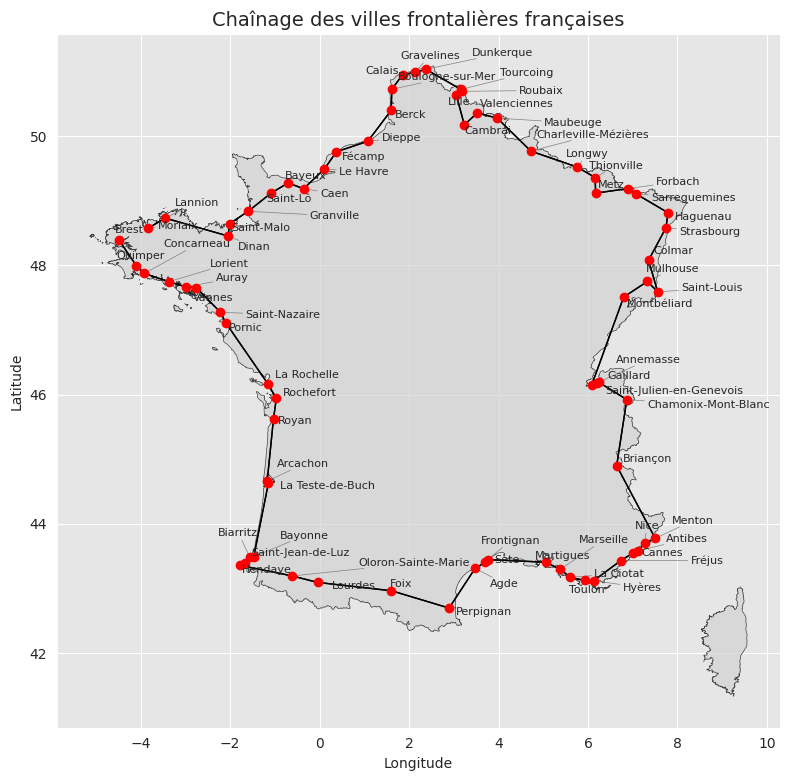

In [7]:
fig, ax = plt.subplots(figsize=(8, 8))
gdf_france.plot(ax=ax, color="lightgray", edgecolor="black", linewidth=0.5, alpha=0.7)

# Tracer les connexions
for (lon1, lat1), (lon2, lat2) in connections:
    ax.plot([lon1, lon2], [lat1, lat2], 'k-', linewidth=1)

# Tracer les villes
ax.scatter(df_border["lon"], df_border["lat"], color='red', zorder=3)

# Ajouter les noms des villes avec ajustement
texts = []
for _, row in df_border.iterrows():
    texts.append(ax.text(row["lon"], row["lat"], row["city"], fontsize=8))

# Ajuster les textes pour éviter le chevauchement
adjust_text(texts, 
            arrowprops=dict(arrowstyle="->", color='gray', lw=0.5),
            ax=ax)

ax.set_title("Chaînage des villes frontalières françaises", fontsize=14)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.grid(True)
plt.tight_layout()
plt.show()

## Apliquer la carte aux prédictions des modèles

In [8]:
lat_columns = [col for col in df.columns if "lat_predicted" in col]
lon_columns = [col for col in df.columns if "lon_predicted" in col]
lat_lon_pairs = [(lat, lat.replace("lat_predicted", "lon_predicted")) for lat in lat_columns if lat.replace("lat_predicted", "lon_predicted") in lon_columns]
for lat_col, lon_col in lat_lon_pairs:
    geom_col = f"geom_{lat_col.replace('lat_predicted', '')}"  # Naming convention
    df[geom_col] = df.apply(lambda row: Point(row[lon_col], row[lat_col]), axis=1)

experiments = [col.split("_lat_predicted")[0] for col in gdf.columns if "lat_predicted" in col]
experiments = list(set(experiments))

In [9]:
for expe in experiments:
    if "Mistral-7B-v0.1_float16_gps_fr" in expe:
        print(expe)

mistralai/Mistral-7B-v0.1_float16_gps_fr


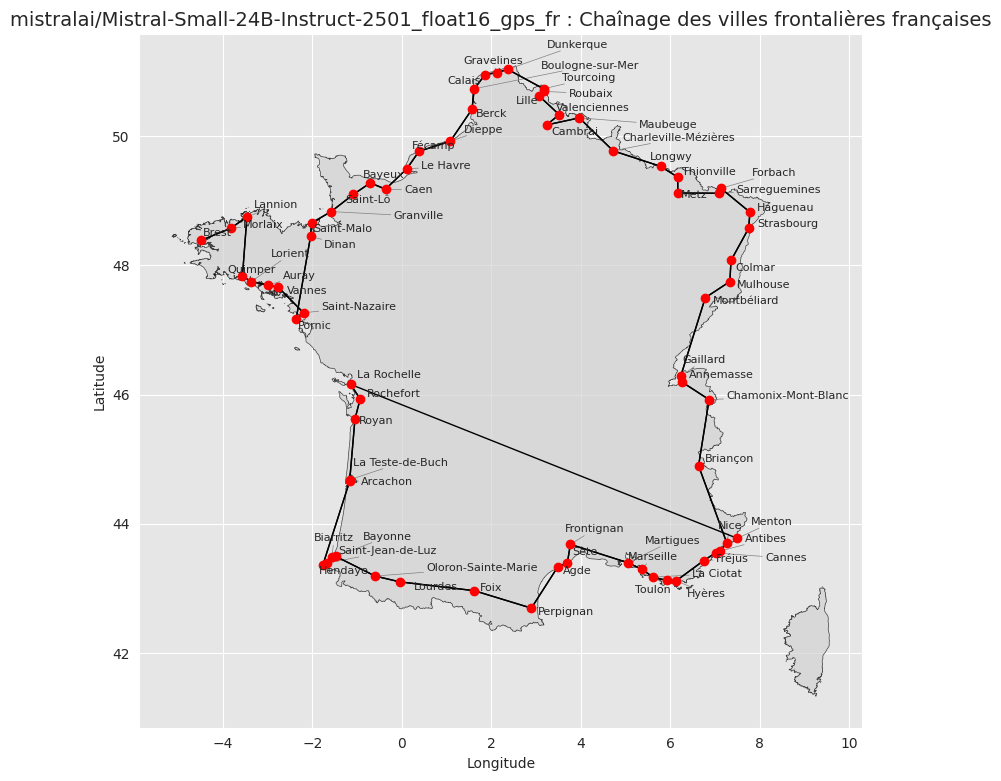

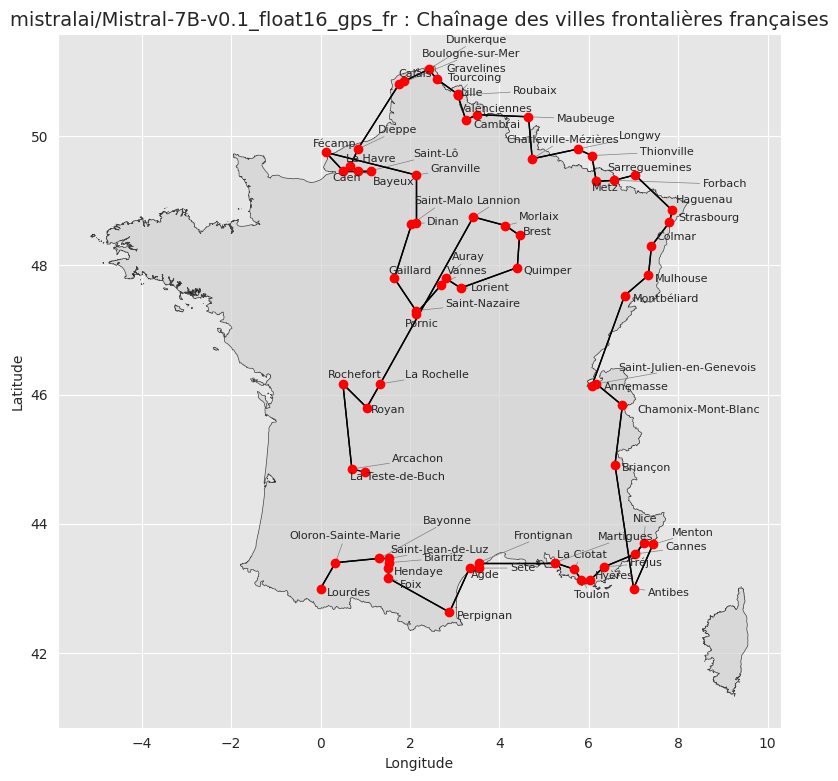

In [13]:
experiments_displayed = [
    "mistralai/Mistral-Small-24B-Instruct-2501_float16_gps_fr",
    "mistralai/Mistral-7B-v0.1_float16_gps_fr"
]

for expe in experiments_displayed:

    df_clean = gdf.dropna(subset=[
        f"{expe}_lat_predicted",
        f"{expe}_lon_predicted"
    ])
    df_border = df_clean[df_clean['city'].isin(border_cities_fr)].copy()
    df_border = df_border[df_border["city"] != "Saint-Louis"]
    df_border = df_border[df_border["city"] != "Concarneau"]
    latitudes = df_border[f"{expe}_lat_predicted"].values
    longitudes = df_border[f"{expe}_lon_predicted"].values
    cities = df_border["city"].values

    # Étape 2 : barycentre
    center_lat = np.mean(latitudes)
    center_lon = np.mean(longitudes)

    # Étape 3 : angle de chaque ville par rapport au centre
    angles = np.arctan2(latitudes - center_lat, longitudes - center_lon)

    # Étape 4 : trier par angle
    sorted_indices = np.argsort(angles)
    sorted_coords = [(cities[i], latitudes[i], longitudes[i]) for i in sorted_indices]

    # Étape 5 : chaînage
    connections = [
        ((c1[2], c1[1]), (c2[2], c2[1]))  # lon, lat
        for c1, c2 in zip(sorted_coords, sorted_coords[1:])
    ]
    
    fig, ax = plt.subplots(figsize=(8, 8))
    gdf_france.plot(ax=ax, color="lightgray", edgecolor="black", linewidth=0.5, alpha=0.7)

    # Tracer les connexions
    for (lon1, lat1), (lon2, lat2) in connections:
        ax.plot([lon1, lon2], [lat1, lat2], 'k-', linewidth=1)

    # Tracer les villes
    ax.scatter(df_border[f"{expe}_lon_predicted"], df_border[f"{expe}_lat_predicted"], color='red', zorder=3)

    # Ajouter les noms des villes avec ajustement
    texts = []
    for _, row in df_border.iterrows():
        texts.append(ax.text(row[f"{expe}_lon_predicted"], row[f"{expe}_lat_predicted"], row["city"], fontsize=8))

    # Ajuster les textes pour éviter le chevauchement
    adjust_text(texts, 
                arrowprops=dict(arrowstyle="->", color='gray', lw=0.5),
                ax=ax)

    ax.set_title(f"{expe} : Chaînage des villes frontalières françaises", fontsize=14)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

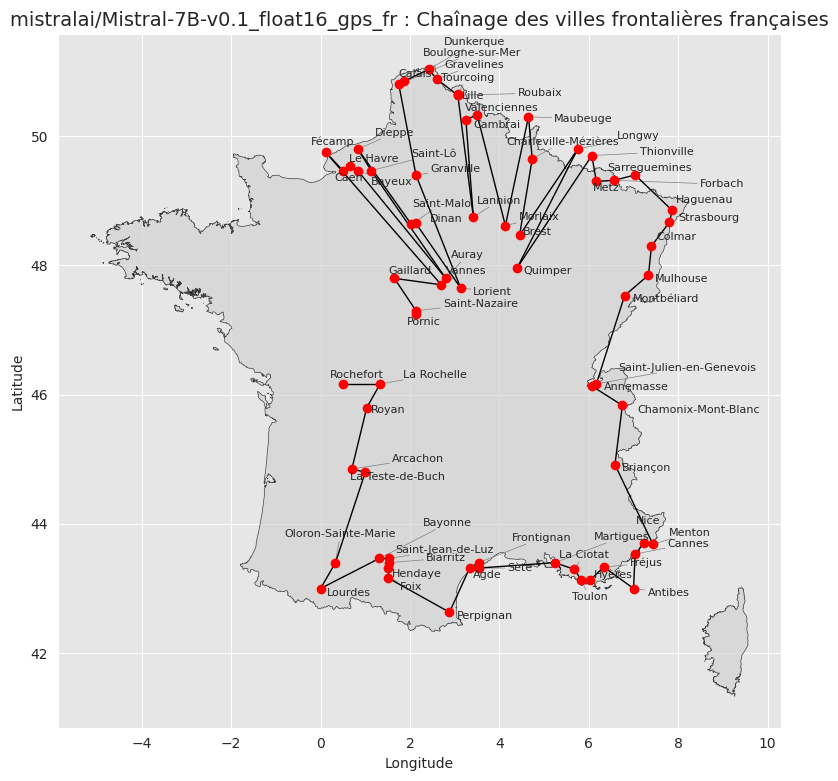

In [17]:
import numpy as np

latitudes = df_border[f"{expe}_lat_predicted"].values
longitudes = df_border[f"{expe}_lon_predicted"].values
cities = df_border["city"].values

# Étape 2 : barycentre
center_lat = np.mean(latitudes)
center_lon = np.mean(longitudes)

# Étape 3 : angle de chaque ville par rapport au centre
angles = np.arctan2(latitudes - center_lat, longitudes - center_lon)

# Étape 4 : trier par angle
sorted_indices = np.argsort(angles)
sorted_coords = [(cities[i], latitudes[i], longitudes[i]) for i in sorted_indices]

# Étape 5 : chaînage
connections = [
    ((c1[2], c1[1]), (c2[2], c2[1]))  # lon, lat
    for c1, c2 in zip(sorted_coords, sorted_coords[1:])
]
fig, ax = plt.subplots(figsize=(8, 8))
gdf_france.plot(ax=ax, color="lightgray", edgecolor="black", linewidth=0.5, alpha=0.7)

# Tracer les connexions
for (lon1, lat1), (lon2, lat2) in connections:
    ax.plot([lon1, lon2], [lat1, lat2], 'k-', linewidth=1)

# Tracer les villes
ax.scatter(df_border[f"{expe}_lon_predicted"], df_border[f"{expe}_lat_predicted"], color='red', zorder=3)

# Ajouter les noms des villes avec ajustement
texts = []
for _, row in df_border.iterrows():
    texts.append(ax.text(row[f"{expe}_lon_predicted"], row[f"{expe}_lat_predicted"], row["city"], fontsize=8))

# Ajuster les textes pour éviter le chevauchement
adjust_text(texts, 
            arrowprops=dict(arrowstyle="->", color='gray', lw=0.5),
            ax=ax)

ax.set_title(f"{expe} : Chaînage des villes frontalières françaises", fontsize=14)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.grid(True)
plt.tight_layout()
plt.show()